# Задание

### Explaining Banking Products (Презентация банковских продуктов)

Несмотря на активное продвижение многоканальных способов контакта с клиентами (omni-channel), встреча «один-на-один» клиентского менеджера (КМ) с клиентом по-прежнему является наиболее продуктивным способом понять нужды и запросы клиентов и предоставить наилучшую комбинацию продуктов и услуг.

Недавно пакет услуг, предоставляемых одним из Больших Банков, был существенно обновлён, и информация о них была доступна клиентам на веб-сайте банка. Изабелла, вице-президент по лояльности и поведению клиентов (customer loyalty and insight), и её команда принимали самое активное участие в разработке этого пакета, а также провели тренинги с КМ о том, как лучше всего объяснить эти услуги клиентам, и разработали пятиминутную презентацию для встречи «один на один» с клиентом. Изабелла считала, что такая презентация клиенту должна существенно повлиять на прибыльность этого клиента в будущем.

Соответственно, был проведен эксперимент: КМ предлагали клиентам, которые были выбраны случайным образом, в течение пяти минут объяснить всю суть нового пакета услуг. У каких-то клиентов не было времени, а какие-то клиенты соглашались прослушать презентацию.

Несколько месяцев спустя, Изабелла с нетерпением подводила итоги эксперимента. Полные данные приведены в файле “Explaining banking products», рабочий лист «Table 1».

Данные по первым пяти клиентам приведены в таблице внизу, где указаны ID клиента (Client ID) и прогнозируемая годовая прибыль (Profit, в USD): слева по клиентам, которые не прослушали презентацию; справа по клиентам, которые прослушали презентацию.

К сожалению, средняя прибыль с презентацией (562.25) оказалась ниже, чем без презентации (591.18). Изабелла пыталась понять, что же могло привести к такому странному и разочаровывающему результату: ведь и она, и её команда были уверены, что обновлённый пакет услуг действительно хорош, и что пятиминутная презентация «один-на-один» была сделана очень профессионально и должна быть полезна. Изабелла скачала данные о профилях клиентов и обратила внимание на их возраст, пол и средне-месячный доход (в USD). Полные данные приведены в файле “Explaining banking products», рабочий лист «Table 2», и данные по первым и последним пяти клиентам приведены ниже.

Изабелла надеялась, что анализ данных поможет понять причину неожиданного уменьшения прибыли по клиентам, которые прослушали презентацию.

# Решение

In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels

from statsmodels.stats.weightstats import *
from scipy.stats import chi2_contingency

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Загрузим данные

In [2]:
df1 = pd.read_excel('Задание 1 (данные)+.xlsx')

No_Presentation_df = df1.iloc[:, :2]
No_Presentation_df.columns = No_Presentation_df.iloc[0]
No_Presentation_df = No_Presentation_df[1:].reset_index(drop=True)
print('Число клиентов без презентации:', No_Presentation_df.shape[0])

Presentation_df = df1.iloc[:, 2:4].dropna()
Presentation_df.columns = Presentation_df.iloc[0]
Presentation_df = Presentation_df[1:].reset_index(drop=True)
print('Число клиентов с презентацией:', Presentation_df.shape[0])

Число клиентов без презентации: 267
Число клиентов с презентацией: 233


In [3]:
df2 = pd.read_excel('Задание 1 (данные)+.xlsx', sheetname ='Table 2', header=1)
print('Совокупное число клиентов:', df2.shape[0])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


Совокупное число клиентов: 500


### Проверим есть ли дубликаты:

для клиентов **без** презентации:

In [4]:
No_Presentation_df[No_Presentation_df['Client ID'].duplicated()]

,Client ID,Profit
33,13472,484.12
138,54289,461


In [5]:
No_Presentation_df[No_Presentation_df['Client ID'] == 13472]

,Client ID,Profit
32,13472,1175.36
33,13472,484.12


In [6]:
No_Presentation_df[No_Presentation_df['Client ID'] == 54289]

,Client ID,Profit
137,54289,752.8
138,54289,461


для клиентов **с** презентацией:

In [7]:
Presentation_df[Presentation_df['Client ID'].duplicated()]

,Client ID,Profit


### Как видно, в выборке клиентов без презентации есть клиенты с одним `id`, но разным `profit`. 
### Проверим наблюдается ли такое в данных с профилями клиентов:

In [8]:
df2[df2['Client ID'].duplicated()]

,Client ID,Age,Gender,Monthly Income
85,13472,45,F,4723.27
283,54289,38,F,5747.42


In [9]:
df2[df2['Client ID'] == 13472]

,Client ID,Age,Gender,Monthly Income
84,13472,38,F,10868.89
85,13472,45,F,4723.27


In [10]:
df2[df2['Client ID'] == 54289]

,Client ID,Age,Gender,Monthly Income
282,54289,35,M,8139.32
283,54289,38,F,5747.42


### Как можно заметить, дубликаты у тех же самых `id`, что и в выборке без презентации, при этом клиенты с одним `id` различаются в других показателях, соответственно и  разный `profit` для таких `id` в этом случае тоже может быть.

### *Предположение 1:*  наблюдается ошибка при присвоении `id` клиентам

### *Предположение 2:* поскольку клиенты с одним `id` в обоих таблицах идут подряд, сделаем соответствие между ними, основываясь на их порядке, т.е.  

        Client ID	 Profit          Client ID	Age	Gender	Monthly Income
    32	13472	   1175.36     84	  13472	 38	     F	     10868.89
    33	13472	   484.12      85	  13472	 45	     F	     4723.27
    
        
         Client ID	 Profit         Client ID	Age	Gender	Monthly Income
    137	 54289	  752.8       282    54289	 35	    M	      8139.32
    138	 54289	  461         283    54289	 38	    F	      5747.42

### Изменим Client ID для таких клиентов, чтобы не возникло повторений при объеденинии таблиц:

In [11]:
No_Presentation_df['Client ID'].iloc[32] = 13472.1
No_Presentation_df['Client ID'].iloc[33] = 13472.2
No_Presentation_df['Client ID'].iloc[137] = 54289.1
No_Presentation_df['Client ID'].iloc[138] = 54289.2

df2['Client ID'].iloc[84] = 13472.1
df2['Client ID'].iloc[85] = 13472.2
df2['Client ID'].iloc[282] = 54289.1
df2['Client ID'].iloc[283] = 54289.2

# print(No_Presentation_df['Client ID'].iloc[32])
# print(No_Presentation_df['Client ID'].iloc[33]) 
# print(No_Presentation_df['Client ID'].iloc[137]) 
# print(No_Presentation_df['Client ID'].iloc[138]) 

# print(df2['Client ID'].iloc[84])
# print(df2['Client ID'].iloc[85])
# print(df2['Client ID'].iloc[282])
# print(df2['Client ID'].iloc[283])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Объеденим таблицы по ключу:

In [12]:
No_Presentation = pd.merge(No_Presentation_df, df2, how='inner', on='Client ID')
Presentation = pd.merge(Presentation_df, df2, how='inner', on='Client ID')

### Проверим среднюю прибыль, совпадает ли она с результатами Изабеллы:

In [13]:
No_Presentation.Profit.mean()

591.1801498127338

In [14]:
Presentation.Profit.mean()

562.2481545064377

### Да, она совпадает. 

# Приступим к анализу данных. 

In [15]:
No_Presentation.head()

,Client ID,Profit,Age,Gender,Monthly Income
0,137,380.37,37,M,4665.64
1,1809,333.11,40,M,4816.03
2,1929,438.91,38,F,2980.46
3,1976,383.21,32,M,4691.48
4,2057,147.46,33,M,4305.03


In [16]:
Presentation.head()

,Client ID,Profit,Age,Gender,Monthly Income
0,43,633.9,37,M,3905.48
1,257,406.61,39,M,4744.88
2,477,382.2,36,M,3815.35
3,754,331.25,31,M,3916.61
4,825,456.01,31,M,3211.30


## 1. Проверим гипотезу о том, что гендерный состав группы людей в двух выборках отличается.

$H_0\colon$ гендерный состав в двух выборках неразличим.

$H_1\colon$ различим.

In [17]:
No_Presentation.Gender.value_counts()

M    138
F    129
Name: Gender, dtype: int64

In [18]:
Presentation.Gender.value_counts()

F    126
M    107
Name: Gender, dtype: int64

In [19]:
gender_df = pd.DataFrame(data={ 'No_Presentation': [138, 129], 'Presentation': [107, 126]},
                                 index = ['Male', 'Female'])  
gender_df.index.name = 'Gender'
gender_df

,No_Presentation,Presentation
Gender,,
Male,138,107
Female,129,126


#### Глядя на таблицу может возникнуть предположение, что т.к. мужчин в выборке с презентацией меньше, чем женщин, в отличие от выборки без, где ситуация наоборот, то и средний доход в этой выборке (с презентацией) тоже меньше по этой причине. Проверим так ли это, оценив средний доход мужчин и женщин в двух выборках:
в No_Presentation:

In [20]:
No_Presentation[No_Presentation['Gender'] == 'M']['Monthly Income'].mean()

5788.958550724637

In [21]:
No_Presentation[No_Presentation['Gender'] == 'F']['Monthly Income'].mean()

5609.684573643412

в Presentation:

In [22]:
Presentation[Presentation['Gender'] == 'M']['Monthly Income'].mean()

4511.279345794396

In [23]:
Presentation[Presentation['Gender'] == 'F']['Monthly Income'].mean()

4636.1150793650795

#### Как оказалось, средний среднемесячный доход в каждой выборке у мужчин и женщин не сильно отличается, поэтому нельзя утверждать, что большее количество мужчин исправило бы ситуацию. Для этого нужно будет проделать более дедальное исследование, если окажется что гендерный состав выборках статитически различим. 

#### Поэтому для начала вернёмся к проверке нулевой гипотезы.

### a) C помощью доверительного интервала для разности двух долей (для независимых выборок):

In [24]:
def proportions_diff_confint_ind(a, n1, b, n2, alpha=0.05):
    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = a / n1
    p2 = b / n2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/n1 + p2 * (1 - p2)/n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/n1 + p2 * (1 - p2)/n2)
    
    return (left_boundary, right_boundary)

In [25]:
a, c = 138, 129
b, d = 107, 126

gender_int = proportions_diff_confint_ind(a, a + c, b, b + d)
gender_int

(-0.030049722172421092, 0.14530265171864287)

### Ответ:
**0 в интервал входит, поэтому нельзя отклонить гипотезу, что различаются**

### b) С помощью статистического критерия (Z-критерий для разности двух долей, независимые выборки):

In [26]:
def proportions_diff_z_stat_ind(a, n1, b, n2):
    
    p1 = a / n1
    p2 = b / n2 
    P = (p1*n1 + p2*n2) / (n1 + n2)

    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [27]:
gender_crit = proportions_diff_z_test(proportions_diff_z_stat_ind(a, a + c, b, b + d))
gender_crit

0.19849838322501157

### Ответ:
**Достигаемый уровень значимости p-value > 0.05. Гипотезу о неотличимости гендерного состава отвергнуть нельзя. Составы статистически не отличаются.**

## 2. Проверим следующие гипотезы о возрасте:
### a) о равенстве медианных значений возрастов людей 
### b) о равенстве распределений возрастов с помощью непараметрического критерия проверки равенства средних (Рангового критерия Манна-Уитни). 

In [28]:
age = No_Presentation.Age.unique()
age.sort()
print(len(age))
print(age)

16
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [29]:
age = Presentation.Age.unique()
age.sort()
print(len(age))
print(age)

16
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [30]:
# pd.DataFrame(data={'age': age,
#              'No_Presentation_counts': No_Presentation.Age.value_counts(sort=False),
#              'Presentation_counts': Presentation.Age.value_counts(sort=False)})

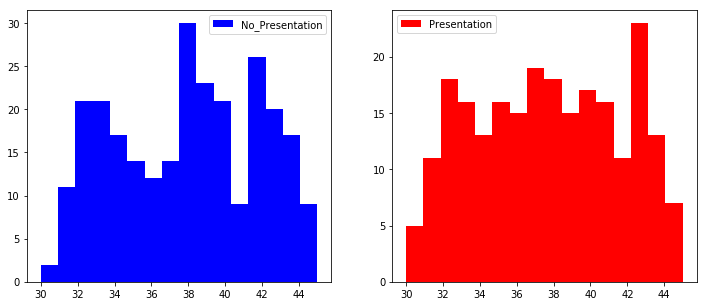

In [31]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(No_Presentation.Age, bins = 16, color = 'b', range = (30, 45), label = 'No_Presentation')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(Presentation.Age, bins = 16, color = 'r', range = (30, 45), label = 'Presentation')
pylab.legend()

pylab.show()

#### По графикам сложно сказать, что возраст людей в двух выборках сильно различается

### a) Проверка гипотезы о равенстве медианных значений возрастов людей

$H_0\colon$ медианные значения возрастов в двух выборках равны.

$H_1\colon$ не равны.

In [32]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

**Интервальная оценка медианы**

In [33]:
No_Presentation_age = No_Presentation.Age.values
Presentation_age = Presentation.Age.values

np.random.seed(0)

No_Presentation_median_scores = list(map(np.median, get_bootstrap_samples(No_Presentation_age, 5000)))
Presentation_median_scores = list(map(np.median, get_bootstrap_samples(Presentation_age, 5000)))

print("95% confidence interval for No_Presentation median age:",  stat_intervals(No_Presentation_median_scores, 0.05))
print("95% confidence interval for Presentation median age:",  stat_intervals(Presentation_median_scores, 0.05))

95% confidence interval for No_Presentation median age: [38. 39.]
95% confidence interval for Presentation median age: [37. 39.]


95% доверительные интервалы медианных значений возрастов в двух выборках пересекаются. По интервальной оценке мы не можем отклонить нулевую гипотезу.

**Интервальная оценка разности медиан**

In [34]:
age_delta_median_scores = list(map(lambda x: x[1] - x[0], zip(Presentation_median_scores, No_Presentation_median_scores)))

print("95% confidence interval for the difference between medians",  stat_intervals(age_delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1.  2.]


### Ответ: 
**гипотеза о равенстве медианных значений возрастов людей не отвергается (т.к. значение 0 входит в 95% доверительный интервал разности медиан)** 

### b) Проверка гипотезы  о равенстве распределений возрастов в двух выборках с помощью непараметрического критерия проверки равенства средних:

**Ранговый критерий Манна-Уитни**

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ - распределения равны.

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ - не равны.

In [35]:
age_crit = stats.mannwhitneyu(No_Presentation.Age, Presentation.Age)
age_crit

MannwhitneyuResult(statistic=29989.0, pvalue=0.24377326765545876)

### Ответ: 
**мы не можем отклонить нулевую гипотезу на уровне значимости 0.05, так как критерий Манна-Уитни дает достигаемый уровень значимости равный 0.24**

## 3. Проверим гипотезы для средне-месячного дохода: 
### a) о равенстве медианных значений средне-месячного дохода с помощью интервальной оценки
### b) о равенстве распределений средне-месячного дохода с помощью непараметрического критерия проверки равенства средних. 

In [36]:
no_p_income = No_Presentation['Monthly Income'].values.copy()
# no_p_income.sort() 
# print(len(no_p_income))
# print(no_p_income)

In [37]:
p_income = Presentation['Monthly Income'].values.copy()
# p_income.sort() 
# print(len(p_income))
# print(p_income)

In [38]:
min_inc = [no_p_income.min(), p_income.min()]
max_inc = [no_p_income.max(), p_income.max()]
mean_inc =[no_p_income.mean(), p_income.mean()]
income_df = pd.DataFrame(data={ 'min':min_inc, 'max':max_inc, 'mean':mean_inc},
                                 index = ['No_Presentation', 'Presentation'])  
income_df.index.name = 'income'
income_df

,min,max,mean
income,,,
No_Presentation,2181.83,13230.15,5702.343034
Presentation,2062.90,8986.40,4578.787082


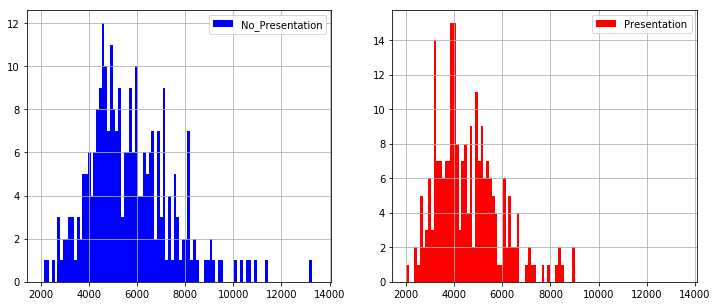

In [39]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(No_Presentation['Monthly Income'], bins = 100, color = 'b', range = (2000, 13500), label = 'No_Presentation')
pylab.legend()

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(Presentation['Monthly Income'], bins = 100, color = 'r', range = (2000, 13500), label = 'Presentation')
pylab.legend()

pylab.show()

### Из двух графиков и информации о миниальном и максимальном доходах клиентов в двух выборках, можно заключить, что в выборке без презентации есть люди у которых доход больше 9000 ${$}$, тогда как в выборке с презентацией максимальный доход не превышает этой суммы. Плюс среднее среднемесячного дохода в двух выборках отличается больше чем на 1000 ${$}$. Возможно в этом и есть причина уменьшения прибыли по клиентам, которые прослушали презентацию.

### a) Проверка гипотезы о равенстве медианных значений средне-месячного дохода с помощью интервальной оценки

$H_0\colon$ медианные значения средне-месячного дохода равны.

$H_1\colon$ не равны.

**Интервальная оценка медианы**

In [40]:
np.random.seed(0)

No_Presentation_median_scores = list(map(np.median, get_bootstrap_samples(no_p_income, 1000)))
Presentation_median_scores = list(map(np.median, get_bootstrap_samples(p_income, 1000)))

print("95% confidence interval for No_Presentation  median income:",  stat_intervals(No_Presentation_median_scores, 0.05))
print("95% confidence interval for Presentation median income:",  stat_intervals(Presentation_median_scores, 0.05))

95% confidence interval for No_Presentation  median income: [5156.83 5750.96]
95% confidence interval for Presentation median income: [4063.6  4615.71]


95% доверительные интервалы медианных значений средне-месячного дохода **не пересекаются**. По интервальной оценке нулевая гипотеза отвергается.

**Интервальная оценка разности медиан**

In [41]:
income_delta_median_scores = list(map(lambda x: x[1] - x[0], zip(Presentation_median_scores, No_Presentation_median_scores)))

print("95% confidence interval for the difference between medians",  stat_intervals(income_delta_median_scores, 0.05))

95% confidence interval for the difference between medians [ 702.738   1522.87525]


### Ответ:
**ноль в интервал не входит, следовательно гипотезу о равенстве медианных значений средне-месячного дохода принять нельзя**

### b) Проверка гиптезы о равенстве распределений средне-месячного дохода с помощью непараметрического критерия проверки равенства средних. 

**Ранговый критерий Манна-Уитни**

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ - распределения равны.

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ - не равны.

In [42]:
income_crit = stats.mannwhitneyu(no_p_income, p_income)
income_crit

MannwhitneyuResult(statistic=18461.0, pvalue=2.155526170012943e-15)

### Ответ:
**Нулевая гипотеза уверено отвергается, p-value << 0.05. Распределение доходов для людей не прослушавших презентацию отличается, от людей прослушавших её.**

----
# Выводы:

## На основе данных, предоставленных Изабеллой, было произведен анализ данных по двум выборкам (тем, кто прослушал презентацию и нет) на основе 3х показателей: гендера, возраста и среднемесячного дохода.

## В результате анализа было, получено:

### 1) на основе гендерного состава:
Не смотря на то, что гендерный состав в двух выборках отличается, в выборке без презентации мужчин больше чем женщин, а выборке с презентацией наоборот (можно увидеть из таблицы ниже):

In [43]:
gender_df

,No_Presentation,Presentation
Gender,,
Male,138,107
Female,129,126


Было показано с помощью вычислений (для независимых выборок) доверительного интервала для разности двух долей и Z-критерия для разности двух долей, что гипотезу о неразличимости гендерного состава отвергнуть нельзя.

Т.к. во-первых, доверительный интервал включает в себя ноль:

In [44]:
gender_int

(-0.030049722172421092, 0.14530265171864287)

А во-вторых, p-value для критерия оказалось больше 0.05:

In [45]:
gender_crit

0.19849838322501157

По этой причине, любое предположение, основаное на различии гендерного состава в выборках, например, что мужчины готовы платить больше, а женщины меньше, не имеет веса, т.к. **статистически гендерный состав в выборках неразличим.**

### 2) на основе возрастного состава:
Тут могла возникнуть такая гипотеза, что от возраста как-то зависит, сколько денег готовы заплатить клиенты, предположив, что возрастной состав в выборках отличается. Но после вычисления интервальной оценки разности медиан значений возрастов в двух выборках и применения рангового критерия Манна-Уитни для проверки гипотезы равенства распределений возрастов опять же было показано, что возрастной состав в группах не различается.

Т.к. значение 0 входит в 95% доверительный интервал разности медиан:

In [46]:
print("95% confidence interval for the difference between age medians",  stat_intervals(age_delta_median_scores, 0.05))

95% confidence interval for the difference between age medians [-1.  2.]


И т.к. распределение возрастов в выборках по критерию Манна-Уитни не отличается. Достигаемый уровень значимости p-value > 0.05:

In [47]:
age_crit

MannwhitneyuResult(statistic=29989.0, pvalue=0.24377326765545876)

Поэтому нельзя принять предположение, что из-за различий в возрасте в двух выборках, доход в выборке с презентацией оказался меньше, т.к. **статистически различий по возрастному составу нет**. 

### 3) на основе среднемесячного дохода:

Только взглянув на таблицу ниже с информацией о минимальной, максимальной и среднем значении доходов клиентов в двух выборках, можно заключить, что в выборке без презентации есть люди у которых доход больше 9000 ${$}$, тогда как в выборке с презентацией максимальный доход не превышает и этой суммы. Более того, среднее среднемесячного дохода в выборке без презентации больше на 1000 ${$}$, чем в выборке с презентацией. Соответствено, было выдвинуто предположение, что в этом и есть причина уменьшения прибыли по клиентам, которые прослушали презентацию. И как оказалось, действительно, проверив гипотезы было показано, что статистически эти выборки по этому покзателю различаются. 

In [48]:
income_df

,min,max,mean
income,,,
No_Presentation,2181.83,13230.15,5702.343034
Presentation,2062.90,8986.40,4578.787082


Для начала была отвергнута гипотеза о равенстве медианных значений средне-месячного дохода на основе интервальной оценки разности медиан (ноль не входит в интервал):

In [49]:
print("95% confidence interval for the difference between income medians",  stat_intervals(income_delta_median_scores, 0.05))

95% confidence interval for the difference between income medians [ 702.738   1522.87525]


Затем по критерию Манна-Уитни была уверено отвергнута нулевая гипотеза о рваенстве распределений средне-месячного дохода, p-value оказалось намного меньше 0.05:

In [50]:
income_crit

MannwhitneyuResult(statistic=18461.0, pvalue=2.155526170012943e-15)

# Итог:

### На основе анализа данных удалось выяснить причину неожиданного уменьшения прибыли по клиентам, которые прослушали презентацию. Этой причиной является то, что среднемесячный доход клиентов в этой выборке оказался статистически отличным (а точнее меньше) от среднемесячного дохода в выборке, где презентацию не слушали. У людей в выборке, где презентация была прослушана, в среднем было меньше денег, поэтому и в среднем доход от таких клиентов оказался меньше. При этом нельзя утверждать, что эксперементальная программа оказалось провальной, т.к. сравнивать результаты на основе этих двух выборок не является верным подходом, ввиду их показаных различий. 